In [1]:
import sys

sys.path.append("./novitskiy/Kandinsky-3/")

In [2]:
!nvidia-smi

Tue Mar 12 17:25:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   27C    P0              66W / 400W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import random
from typing import Optional, Union, List
import PIL
import os

import numpy as np
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
import omegaconf
from omegaconf import OmegaConf
from kandinsky3.model.unet import UNet
from kandinsky3.movq import MoVQ
from kandinsky3.condition_encoders import T5TextConditionEncoder
from kandinsky3.condition_processors import T5TextConditionProcessor
# from kandinsky3.model.diffusion import BaseDiffusion, get_named_beta_schedule

# from kandinsky3.t2i_pipeline import Kandinsky3T2IPipeline
# from kandinsky3.inpainting_pipeline import Kandinsky3InpaintingPipeline
from kandinsky3 import get_T2I_unet, get_T5encoder, get_movq

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)
    

seed_everything(42)

In [6]:
import math

import torch
from einops import rearrange
from tqdm import tqdm
import pdb

from kandinsky3.model.utils import get_tensor_items


def get_named_beta_schedule(schedule_name, timesteps):
    if schedule_name == "linear":
        scale = 1000 / timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, timesteps, dtype=torch.float32
        )
    elif schedule_name == "cosine":
        alpha_bar = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
        betas = []
        for i in range(timesteps):
            t1 = i / timesteps
            t2 = (i + 1) / timesteps
            betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), 0.999))
        return torch.tensor(betas, dtype=torch.float32)


class BaseDiffusion:
    def __init__(self, betas, percentile=None, gen_noise=torch.randn_like):
        self.betas = betas
        self.num_timesteps = betas.shape[0]

        alphas = 1. - betas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.ones(1, dtype=betas.dtype), self.alphas_cumprod[:-1]])

        # calculate q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # calculate q(x_{t-1} | x_t, x_0)
        self.posterior_mean_coef_1 = torch.sqrt(self.alphas_cumprod_prev) * betas / (1. - self.alphas_cumprod)
        self.posterior_mean_coef_2 = torch.sqrt(alphas) * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_variance = betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_log_variance = torch.log(
            torch.cat([self.posterior_variance[1].unsqueeze(0), self.posterior_variance[1:]])
        )

        self.percentile = percentile
        self.time_scale = 1000 // self.num_timesteps
        self.gen_noise = gen_noise
        self.jump_length = 3

    def process_x_start(self, x_start):
        bs, ndims = x_start.shape[0], len(x_start.shape[1:])
        if self.percentile is not None:
            quantile = torch.quantile(
                rearrange(x_start, 'b ... -> b (...)').abs(),
                self.percentile,
                dim=-1
            )
            quantile = torch.clip(quantile, min=1.)
            quantile = quantile.reshape(bs, *((1,) * ndims))
            return torch.clip(x_start, -quantile, quantile) / quantile
        else:
            return torch.clip(x_start, -1., 1.)

    def q_sample(self, x_start, t, noise=None, mask=None):
        if noise is None:
            noise = self.gen_noise(x_start)
        sqrt_alphas_cumprod = get_tensor_items(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod = get_tensor_items(self.sqrt_one_minus_alphas_cumprod, t, noise.shape)
        x_t = sqrt_alphas_cumprod * x_start + sqrt_one_minus_alphas_cumprod * noise
        return x_t

    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean_coef_1 = get_tensor_items(self.posterior_mean_coef_1, t, x_start.shape)
        posterior_mean_coef_2 = get_tensor_items(self.posterior_mean_coef_2, t, x_t.shape)
        posterior_mean = posterior_mean_coef_1 * x_start + posterior_mean_coef_2 * x_t

        posterior_variance = get_tensor_items(self.posterior_variance, t, x_start.shape)
        posterior_log_variance = get_tensor_items(self.posterior_log_variance, t, x_start.shape)
        return posterior_mean, posterior_variance, posterior_log_variance

    # Непосредственно предсказание модели 
    def text_guidance(self, model, x, t, context, context_mask, null_embedding, guidance_weight_text, 
                        uncondition_context=None, uncondition_context_mask=None, mask=None, masked_latent=None):
        large_x = x.repeat(2, 1, 1, 1) # Дублируем нанешнее изоюбражение
        large_t = t.repeat(2) # Дублируем t
        
        # print(context.shape, context_mask.shape, "CONTEXT")
        
        if uncondition_context is None:
            uncondition_context = torch.zeros_like(context)
            uncondition_context_mask = torch.zeros_like(context_mask)
            uncondition_context[:, 0] = null_embedding
            uncondition_context_mask[:, 0] = 1
        
        # print(uncondition_context.shape, uncondition_context_mask.shape, "Uncond CONTEXT")

        large_context = torch.cat([context, uncondition_context])
        large_context_mask = torch.cat([context_mask, uncondition_context_mask])
        
        if mask is not None:
            mask = mask.repeat(2, 1, 1, 1)
        if masked_latent is not None:
            masked_latent = masked_latent.repeat(2, 1, 1, 1)
        
        if model.in_layer.in_channels == 9:
            large_x = torch.cat([large_x, mask, masked_latent], dim=1)
        
        pred_large_noise = model(large_x, large_t * self.time_scale, large_context, large_context_mask.bool())
        pred_noise, uncond_pred_noise = torch.chunk(pred_large_noise, 2) # короче за раз предсказаываем и cond и uncond шум
        pred_noise = (guidance_weight_text + 1.) * pred_noise - guidance_weight_text * uncond_pred_noise
        return pred_noise

    # 
    def p_mean_variance(self, model, x, t, context, context_mask, null_embedding, guidance_weight_text,
                        negative_context=None, negative_context_mask=None, mask=None, masked_latent=None):
        
        pred_noise = self.text_guidance(model, x, t, context, context_mask, null_embedding, guidance_weight_text,
                                        negative_context, negative_context_mask, mask, masked_latent)

        sqrt_one_minus_alphas_cumprod = get_tensor_items(self.sqrt_one_minus_alphas_cumprod, t, pred_noise.shape)
        sqrt_alphas_cumprod = get_tensor_items(self.sqrt_alphas_cumprod, t, pred_noise.shape)
        pred_x_start = (x - sqrt_one_minus_alphas_cumprod * pred_noise) / sqrt_alphas_cumprod
        pred_x_start = self.process_x_start(pred_x_start)

        pred_mean, pred_var, pred_log_var = self.q_posterior_mean_variance(pred_x_start, x, t)
        return pred_mean, pred_var, pred_log_var
    

    # Предсказание шума на i-ом шаге 
    @torch.no_grad()
    def p_sample(self, model, x, t, context, context_mask, null_embedding, guidance_weight_text,
                negative_context=None, negative_context_mask=None, mask=None, masked_latent=None):
        bs = x.shape[0]
        ndims = len(x.shape[1:])
        pred_mean, _, pred_log_var = self.p_mean_variance(model, x, t, context, context_mask, null_embedding, guidance_weight_text,
                                                          negative_context=negative_context,
                                                          negative_context_mask=negative_context_mask,
                                                          mask=mask, masked_latent=masked_latent)
        noise = torch.randn_like(x)
        mask = (t != 0).reshape(bs, *((1,) * ndims))
        sample = pred_mean + mask * torch.exp(0.5 * pred_log_var) * noise
        return sample

    # Генерация за time шагов
    @torch.no_grad()
    def p_sample_loop(self, model, shape, device, context, context_mask, null_embedding, guidance_weight_text,  
                        negative_context=None, negative_context_mask=None, mask=None, masked_latent=None,):
        
        img = torch.randn(*shape, device=device)
        t_start = self.num_timesteps
        time = list(range(t_start))[::-1]
        
        for time in tqdm(time, position=0):
            time = torch.tensor([time] * shape[0], device=device)
            img = self.p_sample(
                model, img, time, context, context_mask, null_embedding, guidance_weight_text, 
                negative_context=negative_context, negative_context_mask=negative_context_mask,
                mask=mask, masked_latent=masked_latent
            )
        return img


def get_diffusion(conf):
    betas = get_named_beta_schedule(**conf.schedule_params)
    base_diffusion = BaseDiffusion(betas, **conf.diffusion_params)
    return base_diffusion

In [7]:
from typing import Optional, Union, List
import PIL
import io
import os
import math
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

import torch
import torchvision.transforms as T
from torch import einsum
from einops import repeat

from kandinsky3.model.unet import UNet
from kandinsky3.movq import MoVQ
from kandinsky3.condition_encoders import T5TextConditionEncoder
from kandinsky3.condition_processors import T5TextConditionProcessor
# from kandinsky3.model.diffusion import BaseDiffusion, get_named_beta_schedule


class Kandinsky3T2IPipeline:
    def __init__(
        self, 
        device: Union[str, torch.device], 
        unet: UNet,
        null_embedding: torch.Tensor,
        t5_processor: T5TextConditionProcessor,
        t5_encoder: T5TextConditionEncoder,
        movq: MoVQ,
        fp16: bool = True
    ):
        self.device = device
        self.fp16 = fp16
        self.to_pil = T.ToPILImage()
        
        self.unet = unet
        self.null_embedding = null_embedding
        self.t5_processor = t5_processor
        self.t5_encoder = t5_encoder
        self.movq = movq
        
    def __call__(
        self, 
        text: str,
        negative_text: str = None,
        images_num: int = 1,
        bs: int = 1, 
        width: int = 1024,
        height: int = 1024,
        guidance_scale: float = 3.0,
        steps: int = 50
    ) -> List[PIL.Image.Image]:

        betas = get_named_beta_schedule('cosine', steps)
        base_diffusion = BaseDiffusion(betas, 0.99)
        
        condition_model_input, negative_condition_model_input = self.t5_processor.encode(text, negative_text)
        for key in condition_model_input:
            for input_type in condition_model_input[key]:
                condition_model_input[key][input_type] = condition_model_input[key][input_type].unsqueeze(0).to(self.device)

        if negative_condition_model_input is not None:
            for key in negative_condition_model_input:
                for input_type in negative_condition_model_input[key]:
                    negative_condition_model_input[key][input_type] = negative_condition_model_input[key][input_type].unsqueeze(0).to(self.device)
        
        pil_images = []
        with torch.cuda.amp.autocast(enabled=self.fp16):
            with torch.no_grad():
                context, context_mask = self.t5_encoder(condition_model_input)
                if negative_condition_model_input is not None:
                    negative_context, negative_context_mask = self.t5_encoder(negative_condition_model_input)
                else:
                    negative_context, negative_context_mask = None, None

                k, m = images_num // bs, images_num % bs
                for minibatch in [bs] * k + [m]:
                    if minibatch == 0:
                        continue
                    bs_context = repeat(context, '1 n d -> b n d', b=minibatch)
                    bs_context_mask = repeat(context_mask, '1 n -> b n', b=minibatch)
                    if negative_context is not None:
                        bs_negative_context = repeat(negative_context, '1 n d -> b n d', b=minibatch)
                        bs_negative_context_mask = repeat(negative_context_mask, '1 n -> b n', b=minibatch)
                    else:
                        bs_negative_context, bs_negative_context_mask = None, None
                    print(bs_context.shape, bs_context_mask.shape)
                    images = base_diffusion.p_sample_loop(
                        self.unet, (minibatch, 4, height//8, width//8), self.device, 
                        bs_context, bs_context_mask, self.null_embedding, guidance_scale,
                        negative_context=bs_negative_context, negative_context_mask=bs_negative_context_mask
                    )

                    images = torch.cat([self.movq.decode(image) for image in images.chunk(2)])
                    images = torch.clip((images + 1.) / 2., 0., 1.)
                    for images_chunk in images.chunk(1):
                        pil_images += [self.to_pil(image) for image in images_chunk]

        return pil_images

In [8]:
device = "cuda"
fp16 = False
cache_dir = '/tmp/kandinsky3/'

    
unet_path = hf_hub_download(
    repo_id="ai-forever/Kandinsky3.0", filename='weights/kandinsky3.pt', cache_dir=cache_dir
)

text_encode_path = 'google/flan-ul2'

movq_path = hf_hub_download(
    repo_id="ai-forever/Kandinsky3.0", filename='weights/movq.pt', cache_dir=cache_dir
)

unet, null_embedding, projections_state_dict = get_T2I_unet(device, unet_path, fp16=fp16)
processor, condition_encoders = get_T5encoder(device, text_encode_path, projections_state_dict, fp16=fp16)
movq = get_movq(device, movq_path, fp16=fp16)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
t2i_pipe = Kandinsky3T2IPipeline(
                device, unet, null_embedding, processor, condition_encoders, movq, fp16=fp16
           )

torch.Size([1, 44, 4096]) torch.Size([1, 44])


  0%|          | 0/50 [00:00<?, ?it/s]/home/jovyan/.mlspace/envs/kandinsky4/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


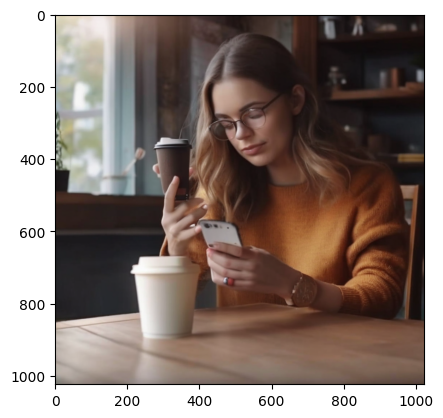

In [10]:
image = t2i_pipe("A woman sitting at the table. She has a phone in her left hand and a cup of coffe in the right hand. One plastic cup of Coffee on the table. Real image, 4k")
plt.imshow(image[0])

# DDIM Inversion

In [11]:
null_embedding.shape

torch.Size([4096])

In [12]:
null_context = null_embedding.unsqueeze(0).repeat(1, 1).unsqueeze(0)
null_context_mask = torch.ones((1, 1), dtype=torch.bool)

null_context.shape, null_context_mask.shape

(torch.Size([1, 1, 4096]), torch.Size([1, 1]))

In [13]:
PROMPT = "Puppy sitting on the grass"

condition_model_input, negative_condition_model_input = processor.encode(PROMPT, None)

for key in condition_model_input:
    for input_type in condition_model_input[key]:
        condition_model_input[key][input_type] = condition_model_input[key][input_type].unsqueeze(0).to(device)

context, context_mask = condition_encoders(condition_model_input)
context_mask = context_mask.bool()

context.shape, context_mask.shape

(torch.Size([1, 8, 4096]), torch.Size([1, 8]))

In [14]:
PROMPT_2 = "Kitten sitting on the grass"

condition_model_input, negative_condition_model_input = processor.encode(PROMPT_2, None)

for key in condition_model_input:
    for input_type in condition_model_input[key]:
        condition_model_input[key][input_type] = condition_model_input[key][input_type].unsqueeze(0).to(device)

context_2, context_mask_2 = condition_encoders(condition_model_input)
context_mask_2 = context_mask_2.bool()

context_2.shape, context_mask_2.shape

(torch.Size([1, 8, 4096]), torch.Size([1, 8]))

In [15]:
uncondition_context = torch.zeros_like(context)
uncondition_context_mask = torch.zeros_like(context_mask)
uncondition_context[:, 0] = null_embedding
uncondition_context_mask[:, 0] = 1

uncondition_context_mask = uncondition_context_mask.bool()

uncondition_context.shape, uncondition_context_mask.shape

(torch.Size([1, 8, 4096]), torch.Size([1, 8]))

In [16]:
from diffusers import DDIMScheduler, DDIMInverseScheduler

noise_scheduler = DDIMScheduler(clip_sample=False, beta_schedule="squaredcos_cap_v2")
inverse_noise_scheduler = DDIMInverseScheduler(num_train_timesteps=1000, clip_sample=True, beta_schedule="squaredcos_cap_v2")

noise_scheduler.set_timesteps(num_inference_steps=100)
inverse_noise_scheduler.set_timesteps(num_inference_steps=100)

In [17]:
from PIL import Image
import torchvision.transforms as transforms 


image_path = "./novitskiy/dog/dog.png"
m_ref_path = "./novitskiy/dog/dog_m_ref.png"
m_gud_path = "./novitskiy/dog/dog_m_gud.png"
m_gen_path = "./novitskiy/dog/dog_m_gen.png"

image = Image.open(image_path)
m_ref = Image.open(m_ref_path) 
m_gud = Image.open(m_gud_path) 
m_gen = Image.open(m_gen_path) 


transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x[:, :, 200:]),
    transforms.Resize((1024, 1024)),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

transform_mask = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x[:, :, 200:]),
    transforms.Resize((128, 128)),
    # transforms.Lambda(lambda t: (t * 2) - 1),
    transforms.Lambda(lambda t: t[0].bool())
])

inverse_scale = transforms.Lambda(lambda t: (t + 1) / 2)

image = transform(image)[:3].unsqueeze(0)
m_ref = transform_mask(m_ref).unsqueeze(0).unsqueeze(0)
m_gud = transform_mask(m_gud).unsqueeze(0).unsqueeze(0)
# m_gen = transform_mask(m_gen).unsqueeze(0).unsqueeze(0)
image.shape, m_gud.shape

/home/jovyan/.mlspace/envs/kandinsky4/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([1, 3, 1024, 1024]), torch.Size([1, 1, 128, 128]))

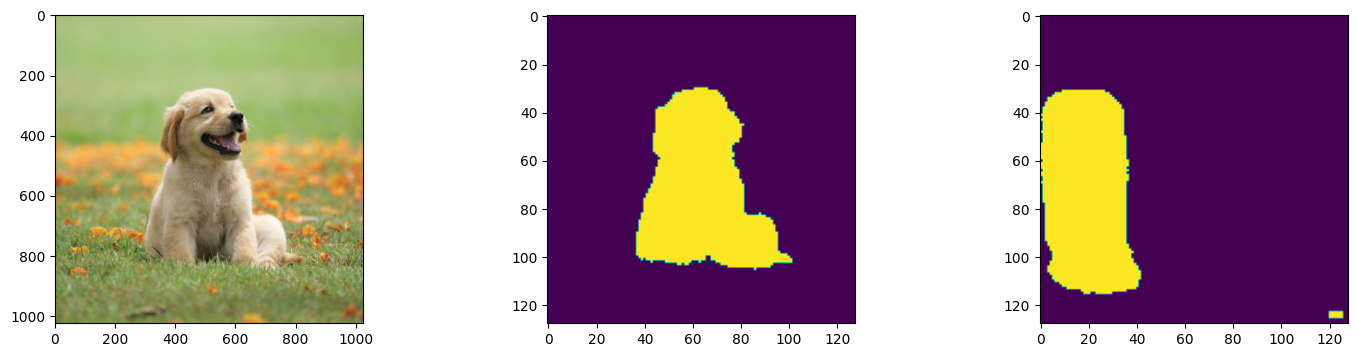

In [18]:
f, axarr = plt.subplots(1, 3, figsize=(18, 4))
axarr[0].imshow(inverse_scale(image[0]).permute(1, 2, 0).cpu())
axarr[1].imshow(inverse_scale(m_gud[0].bool()).permute(1, 2, 0).cpu())
axarr[2].imshow(inverse_scale(m_ref[0].bool()).permute(1, 2, 0).cpu())

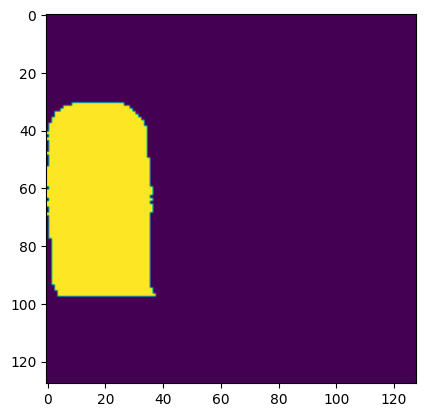

In [19]:
m_ref[:, :, -30:] = False


plt.imshow(m_ref[0][0])

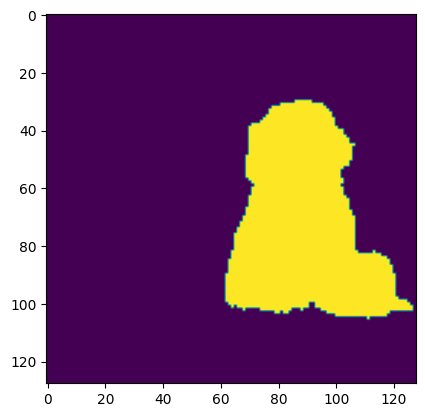

In [20]:
m_gen = torch.cat([
    torch.zeros(1, 1, 128, 25).bool(),
    m_gud[:, :, :, :-25]
], dim=-1)

plt.imshow(m_gen[0][0])

In [21]:
m_gud.type(), m_gen.type(), m_gud.shape, m_gen.shape

('torch.BoolTensor',
 'torch.BoolTensor',
 torch.Size([1, 1, 128, 128]),
 torch.Size([1, 1, 128, 128]))

In [22]:
img_latent = movq.encode(image.to(device))
print(img_latent.shape, "Latent shape")

torch.Size([1, 4, 128, 128]) Latent shape


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


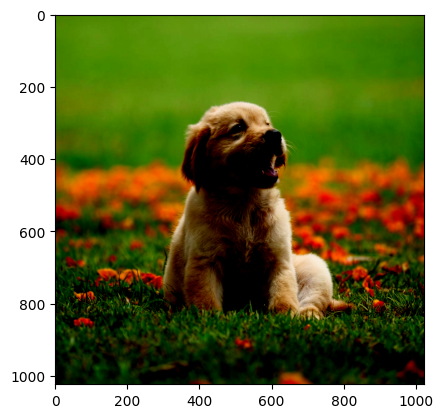

In [23]:
img_pixel = movq.decode(img_latent)
plt.imshow(img_pixel[0].permute(1, 2, 0).cpu())
print(img_pixel.shape, "Pixel shape")

Вот тут хз надо ли делать гайденс)))) в DDIM INVERSION WITH MEMORY BANK ничего про c не сказано, а в коде на GH на DDIM Inversion, они используют текст)

Но не делают гайденс. Я сделал так же)

In [24]:
def next_step(scheduler, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
    timestep, next_timestep = min(timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps, 999), timestep
    alpha_prod_t = scheduler.alphas_cumprod[timestep] if timestep >= 0 else scheduler.final_alpha_cumprod
    alpha_prod_t_next = scheduler.alphas_cumprod[next_timestep]
    beta_prod_t = 1 - alpha_prod_t
    next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
    next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
    next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
    return next_sample


def get_noise_pred(model, latent, t, context, context_mask, uncondition_context, uncondition_context_mask, cfg_scale):    
    noise_pred_cond, ks, vs = unet(latent, t,  context=context, context_mask=context_mask, return_decoder_kv=True)
    # noise_pred_uncond, ks, vs = unet(latent, t,  context=uncondition_context, context_mask=uncondition_context_mask, K=None, V=None, return_decoder_kv=True)
    
    # noise_pred = cfg_scale * noise_pred_cond - (1 - cfg_scale) * noise_pred_uncond

    # return noise_pred
    
    return noise_pred_cond, ks, vs
    

@torch.no_grad()
def ddim_reverse_loop(model, scheduler, Z0, context, context_mask, uncondition_context, uncondition_context_mask, cfg_scale):
    all_latent = [Z0]
    all_ks = []
    all_vs = []
    
    latent = Z0.clone().detach()
    
    for i in tqdm(range(scheduler.num_inference_steps)):
        t = scheduler.timesteps[len(scheduler.timesteps) - i - 1]
        t_batch = torch.tensor([t.item()], device=device)
        
        noise_pred, ks, vs = get_noise_pred(model, latent, t_batch, context, context_mask, uncondition_context, uncondition_context_mask, cfg_scale)
        latent = next_step(scheduler, noise_pred, t, latent)
        
        all_latent.append(latent)
        all_ks.append(ks)
        all_vs.append(vs)
        
    return all_latent, all_ks, all_vs


@torch.no_grad()
def ddim_inversion(model, scheduler, Z0, context, context_mask, uncondition_context, uncondition_context_mask, cfg_scale):
    laents = ddim_reverse_loop(model, scheduler, Z0, context, context_mask, uncondition_context, uncondition_context_mask, cfg_scale)
    return laents

In [25]:
latents, ks, vs = ddim_inversion(
    model=unet, 
    scheduler=noise_scheduler, 
    Z0=img_latent.to(device), 
    context=context.to(device), 
    context_mask=context_mask.to(device), 
    uncondition_context=null_context.to(device), 
    uncondition_context_mask=null_context_mask.to(device), 
    cfg_scale=1.0
)

# latents

100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


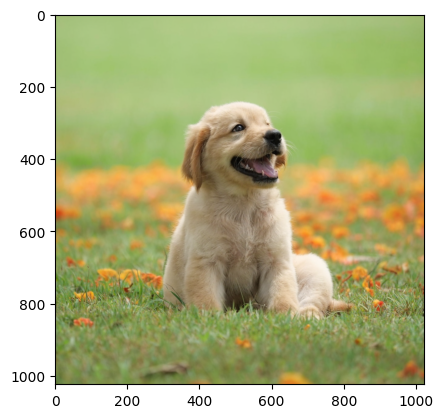

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


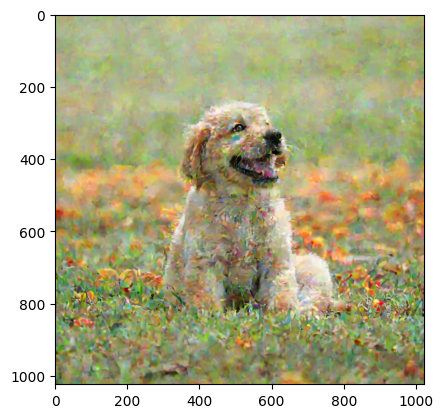

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


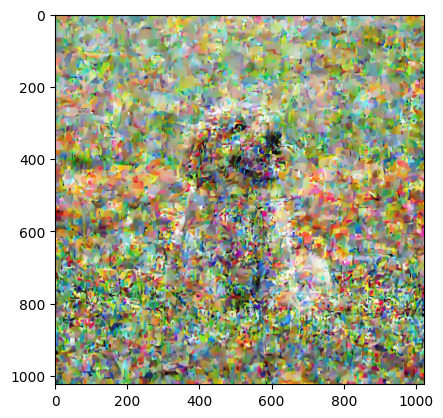

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


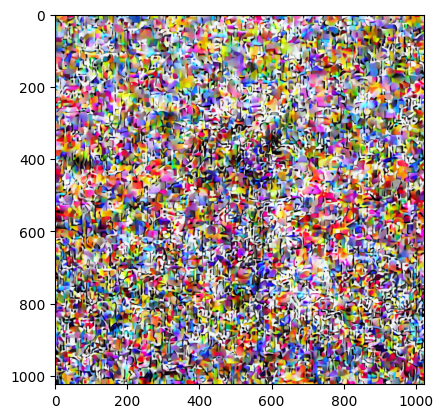

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


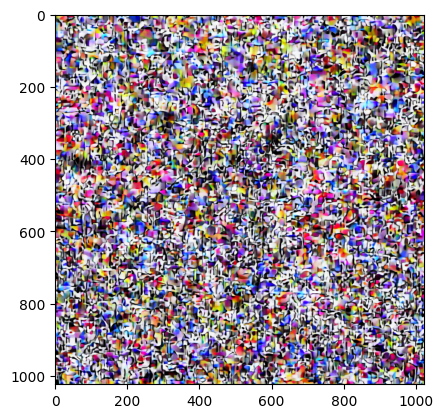

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


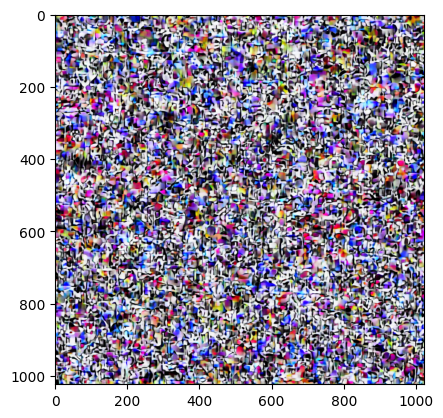

In [26]:
for latent in latents[::20]:
    decoded_inversion = movq.decode(latent)
    plt.imshow(inverse_scale(decoded_inversion)[0].permute(1, 2, 0).cpu())
    print(decoded_inversion.shape, "Pixel shape")

    plt.show()

In [319]:
from kandinsky3.model.utils import exist


class DragonDiffusion:
    def __init__(self, betas, percentile=None, device: str = "cuda", gen_noise=torch.randn_like):
        betas = betas.clone().to(device)
        self.betas = betas
        self.num_timesteps = betas.shape[0]

        alphas = 1. - betas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.ones(1, dtype=betas.dtype, device=device), self.alphas_cumprod[:-1]])

        # calculate q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # calculate q(x_{t-1} | x_t, x_0)
        self.posterior_mean_coef_1 = torch.sqrt(self.alphas_cumprod_prev) * betas / (1. - self.alphas_cumprod)
        self.posterior_mean_coef_2 = torch.sqrt(alphas) * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_variance = betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_log_variance = torch.log(
            torch.cat([self.posterior_variance[1].unsqueeze(0), self.posterior_variance[1:]])
        )

        self.percentile = percentile
        self.time_scale = 1000 // self.num_timesteps
        self.gen_noise = gen_noise
        
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def process_x_start(self, x_start):
        bs, ndims = x_start.shape[0], len(x_start.shape[1:])
        if self.percentile is not None:
            quantile = torch.quantile(
                rearrange(x_start, 'b ... -> b (...)').abs(),
                self.percentile,
                dim=-1
            )
            quantile = torch.clip(quantile, min=1.)
            quantile = quantile.reshape(bs, *((1,) * ndims))
            return torch.clip(x_start, -quantile, quantile) / quantile
        else:
            return torch.clip(x_start, -1., 1.)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = self.gen_noise(x_start)
        sqrt_alphas_cumprod = get_tensor_items(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod = get_tensor_items(self.sqrt_one_minus_alphas_cumprod, t, noise.shape)
        x_t = sqrt_alphas_cumprod * x_start + sqrt_one_minus_alphas_cumprod * noise
        return x_t

    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean_coef_1 = get_tensor_items(self.posterior_mean_coef_1, t, x_start.shape)
        posterior_mean_coef_2 = get_tensor_items(self.posterior_mean_coef_2, t, x_t.shape)
        posterior_mean = posterior_mean_coef_1 * x_start + posterior_mean_coef_2 * x_t

        posterior_variance = get_tensor_items(self.posterior_variance, t, x_start.shape)
        posterior_log_variance = get_tensor_items(self.posterior_log_variance, t, x_start.shape)
        return posterior_mean, posterior_variance, posterior_log_variance
    
    def q_posterior_variance(self, t, prev_t, shape, eta=1.,):
        alphas_cumprod = get_tensor_items(self.alphas_cumprod, t, shape)
        prev_alphas_cumprod = get_tensor_items(self.alphas_cumprod, prev_t, shape)

        posterior_variance = torch.sqrt(
            eta * (1. - alphas_cumprod / prev_alphas_cumprod) * (1. - prev_alphas_cumprod) / (1. - alphas_cumprod)
        )
        return posterior_variance
    
    def get_x_start(self, x, t, noise):
        sqrt_one_minus_alphas_cumprod = get_tensor_items(self.sqrt_one_minus_alphas_cumprod, t, noise.shape)
        sqrt_alphas_cumprod = get_tensor_items(self.sqrt_alphas_cumprod, t, noise.shape)
        pred_x_start = (x - sqrt_one_minus_alphas_cumprod * noise) / sqrt_alphas_cumprod
        return pred_x_start
    
    def get_noise(self, x, t, x_start):
        sqrt_one_minus_alphas_cumprod = get_tensor_items(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        sqrt_alphas_cumprod = get_tensor_items(self.sqrt_alphas_cumprod, t, x_start.shape)
        pred_noise = (x - sqrt_alphas_cumprod * x_start) / sqrt_one_minus_alphas_cumprod
        return pred_noise

    
    def pred_noise(
        self, model, Z_t_gen, Z_t_gud, m_gen, m_gud, m_ref, t, context, context_mask, null_context, guidance_weight, K_t=None, V_t=None,
        uncondition_context=None, uncondition_context_mask=None
    ):
        # large_x = x.repeat(2, 1, 1, 1)
        # large_t = t.repeat(2)
        # if uncondition_context is None:
        #     uncondition_context = torch.zeros_like(context)
        #     uncondition_context_mask = torch.zeros_like(context_mask)
        #     uncondition_context[:, 0] = null_embedding
        #     uncondition_context_mask[:, 0] = 1
        # large_context = torch.cat([context, uncondition_context])
        # large_context_mask = torch.cat([context_mask, uncondition_context_mask])
        w_edit = 4
        w_content = 6
        w_contrast = 0.2
        w_inpaint = 0.8
        loss_scale = [0.25, 0.25, 0.25, 0.25]
        energy_scale = 500
        guidance_weight = 1
        
        bs = Z_t_gen.shape[0]
        
        """"
        εˆ = ε (zgen, K , V , t, c); вот утт не надо делать CFG
        """

        # Extract F_t_gen
        Z_t_gen_copy = latent.clone().detach().requires_grad_(True)
        # with torch.no_grad():
        F_t_gen = model(Z_t_gen_copy, t * self.time_scale, context=null_context, return_multi_scale_features=True, return_decoder_kv=False)[1]
        # Make them all the same H, W
        F_t_gen = [F.interpolate(el, (F_t_gen[-1].shape[-2], F_t_gen[-1].shape[-1])) for el in F_t_gen]
        
        # Extract F_t_gud
        with torch.no_grad():
            F_t_gud = model(Z_t_gud, t * self.time_scale, context=null_context, return_multi_scale_features=True, return_decoder_kv=False)[1]
        # Make them all the same H, W
        F_t_gud = [F.interpolate(el, (F_t_gud[-1].shape[-2], F_t_gud[-1].shape[-1])) for el in F_t_gud]
        
        
        # print([el.shape for el in F_t_gen])
        # print([el.shape for el in F_t_gud])
        # print(m_gen.shape, m_gud.shape)
        
        """
        tar - исходная
        cur - сдвинутый tar т.е. целевая
        
        gud - исходная
        gen - целевая
        """
        
        
        guidance = 0
        # print(t.item())
        if t.item() > 70:
            # Edit Energy
            loss_edit = 0
            for f_id in range(len(F_t_gud)):
                F_t_gen_vec = F_t_gen[f_id][m_gen.repeat(1, F_t_gen[f_id].shape[1], 1, 1)]
                F_t_gud_vec = F_t_gud[f_id][m_gud.repeat(1, F_t_gud[f_id].shape[1], 1, 1)]

                # print(F_t_gen_vec.shape, F_t_gud_vec.shape)

                F_t_gen_vec = F_t_gen_vec.view(bs, F_t_gen[f_id].shape[1], -1).permute(0, 2, 1)
                F_t_gud_vec = F_t_gud_vec.view(bs, F_t_gud[f_id].shape[1], -1).permute(0, 2, 1)

                # print(F_t_gen_vec.shape, F_t_gud_vec.shape)

                sim = self.cos(F_t_gen_vec, F_t_gud_vec)

                # print(m_gud.sum())
                # print(sim.shape)

                sim_global = self.cos(F_t_gen_vec.mean(0, keepdim=True), F_t_gud_vec.mean(0, keepdim=True))
                loss_edit = loss_edit + (w_edit / (1 + 4 * sim.mean())) * loss_scale[f_id] 

            
            mask_non_overlap = torch.logical_and(torch.logical_or(m_gen, m_gud), torch.logical_not(torch.logical_and(m_gen, m_gud)))
            mask_non_overlap_gud = (m_gud.float() - torch.logical_and(m_gen, m_gud).float()).bool()

            # Content Energy
            loss_con = 0
            for f_id in range(len(F_t_gud)):
                sim_other = self.cos(F_t_gud[f_id], F_t_gen[f_id])[0][m_ref[0,0]]
                loss_con = loss_con + w_content / (1 + 4 * sim_other.mean()) * loss_scale[f_id]
            
            for f_id in range(len(F_t_gud)):
                F_t_gen_non_overlap = F_t_gen[f_id][mask_non_overlap.repeat(1,F_t_gen[f_id].shape[1], 1, 1)].view(F_t_gen[f_id].shape[1], -1).permute(1,0)
                F_t_gud_non_overlap = F_t_gud[f_id][mask_non_overlap.repeat(1,F_t_gud[f_id].shape[1], 1, 1)].view(F_t_gud[f_id].shape[1], -1).permute(1,0)
                sim_non_overlap = (self.cos(F_t_gen_non_overlap, F_t_gud_non_overlap) + 1.) / 2.
                loss_con = loss_con + w_contrast * sim_non_overlap.mean() * loss_scale[f_id]
                
                F_t_gen_non_overlap = F_t_gen[f_id][mask_non_overlap.repeat(1, F_t_gen[f_id].shape[1], 1, 1)].view(F_t_gen[f_id].shape[1],-1).permute(1,0).mean(0, keepdim=True)
                F_t_gud_non_overlap = F_t_gud[f_id][m_ref.repeat(1, F_t_gud[f_id].shape[1], 1, 1)].view(F_t_gud[f_id].shape[1],-1).permute(1,0).mean(0, keepdim=True)
                sim_inpaint = ((self.cos(F_t_gen_non_overlap, F_t_gud_non_overlap) + 1.) / 2.)
                loss_con = loss_con + w_inpaint / (1 + 4 * sim_inpaint.mean())

        
            # Gradient
            cond_grad_edit = torch.autograd.grad(loss_edit * energy_scale, Z_t_gen_copy, retain_graph=True)[0]
            cond_grad_con = torch.autograd.grad(loss_con * energy_scale, Z_t_gen_copy)[0]

            # mask_edit2 = (F.interpolate(m_gud, (g_gen.shape[-2], g_gen.shape[-1]))).float()
            mask_edit1 = m_gen.float()
            
            # mask = ((m_gen + mask_edit2) > 0.5).float()

            # mask_edit2 = m_gud.float()
            
            guidance = cond_grad_edit.detach() * 500 * mask_edit1  + cond_grad_con.detach() * 250 * (1 - mask_edit1)
    
    
            # print(cond_grad_edit)

       
        # print([el.shape for el in F_t_gen])
        # print([el.shape for el in F_t_gud])
        with torch.no_grad():
            pred_noise_cond = model(
                Z_t_gen, 
                t * self.time_scale, 
                context=context, context_mask=context_mask, 
                K=K_t, V=V_t, 
                return_multi_scale_features=False, return_decoder_kv=False
            )
            
            pred_noise_uncond = model(
                Z_t_gen, 
                t * self.time_scale, 
                context=null_context, 
                K=K_t, V=V_t, 
                return_multi_scale_features=False, return_decoder_kv=False
            )
            
        pred_noise = (guidance_weight + 1.) * pred_noise_cond - guidance_weight * pred_noise_uncond
        # pred_noise, uncond_pred_noise = torch.chunk(pred_large_noise, 2)
        # pred_noise = guidance_weight * pred_noise - (1 - guidance_weight) * uncond_pred_noise
        
        """
        if T − t < n then
            E = w_e * E_edit + w_c * E_content + w_o * E_opt;
            εˆ = εˆ + η * ∇ E ;
        """
        
        return pred_noise + guidance

    def p_mean_variance(
        self, model, Z_t_gen, Z_t_gud, m_gen, m_gud, m_ref, t, prev_t, context, context_mask, null_context, guidance_weight, K_t=None, V_t=None, eta=1.,
        negative_context=None, negative_context_mask=None
    ):
        pred_noise = self.pred_noise(
            model, Z_t_gen, Z_t_gud, m_gen, m_gud, m_ref, t, context, context_mask, null_context, guidance_weight, K_t, V_t, negative_context, negative_context_mask
        )
        pred_x_start = self.get_x_start(Z_t_gen, t, pred_noise)
        pred_x_start = self.process_x_start(pred_x_start)
        pred_noise = self.get_noise(Z_t_gen, t, pred_x_start)
        pred_var = self.q_posterior_variance(t, prev_t, Z_t_gen.shape, eta)
        
        prev_alphas_cumprod = get_tensor_items(self.alphas_cumprod, prev_t, Z_t_gen.shape)
        pred_mean = torch.sqrt(prev_alphas_cumprod) * pred_x_start
        pred_mean += torch.sqrt(1. - prev_alphas_cumprod - pred_var**2) * pred_noise
        return pred_mean, pred_var


    def p_sample(
        self, model, Z_t_gen, Z_t_gud, m_gen, m_gud, m_ref, t, prev_t, context, context_mask, null_context, guidance_weight, K_t=None, V_t=None, eta=1.,
        negative_context=None, negative_context_mask=None
    ):
        bs = Z_t_gen.shape[0]
        ndims = len(Z_t_gen.shape[1:])
        pred_mean, pred_var = self.p_mean_variance(
            model, Z_t_gen, Z_t_gud, m_gen, m_gud, m_ref, t, prev_t, context, context_mask, null_context, guidance_weight, K_t, V_t, eta,
            negative_context, negative_context_mask
        )
        noise = torch.randn_like(Z_t_gen)
        mask = (prev_t != 0).reshape(bs, *((1,) * ndims))
        sample = pred_mean + mask * pred_var * noise
        return sample


    def p_sample_loop(
        self, Z_t_guds, m_gen, m_gud, m_ref, model, shape, device, context, context_mask, null_context, guidance_weight, times, K=None, V=None, eta=1.,
        negative_context=None, negative_context_mask=None
    ):
        # img = torch.randn(*shape, device=device)
        times = times + [0,]
        times = list(zip(times[:-1], times[1:]))
        
        Z_t_gen = Z_t_guds[-1]
        Z_t_gens = [Z_t_gen]
        
        K_t, V_t = None, None
        
        for t, prev_time in tqdm(times):
            if exist(K) and exist(V):
                K_t, V_t = K[t], V[t]

            time = torch.tensor([t] * Z_t_gen.shape[0], device=device)
            prev_time = torch.tensor([prev_time] * Z_t_gen.shape[0], device=device)
            
            Z_t_gud = Z_t_guds[t]

            Z_t_gen = self.p_sample(
                model, Z_t_gen, Z_t_gud, m_gen, m_gud, m_ref, time, prev_time, context, context_mask, null_context, guidance_weight, K_t, V_t, eta,
                negative_context, negative_context_mask
            )
            
            Z_t_gens.append(Z_t_gen)
        return Z_t_gens

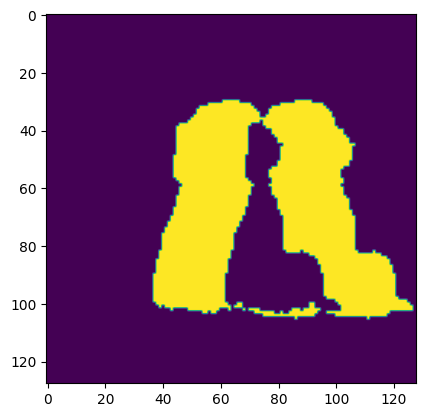

In [300]:
mask_non_overlap = torch.logical_and(torch.logical_or(m_gen, m_gud), torch.logical_not(torch.logical_and(m_gen, m_gud)))
plt.imshow(mask_non_overlap[0][0])

In [320]:
betas = get_named_beta_schedule('cosine', 100)
base_diffusion = DragonDiffusion(betas, 0.99, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


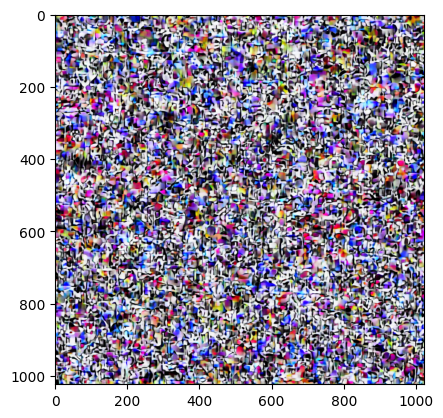

In [321]:
decoded_inversion = movq.decode(latents[-1])
plt.imshow(transforms.Lambda(lambda t: (t + 1) / 2)(decoded_inversion)[0].permute(1, 2, 0).cpu())
print(decoded_inversion.shape, "Pixel shape")

In [322]:
# plt.imshow(torch.logical_or(m_gen, m_gud)[0, 0])

In [323]:
# plt.imshow(
#     torch.logical_and(torch.logical_or(m_gen, m_gud), torch.logical_not(torch.logical_and(m_gen, m_gud)))[0, 0]
# )

In [324]:
print(len(ks), len(ks[0]), ks[0][0].shape, ks[0][1].shape, ks[0][2].shape)
print(len(ks), len(ks[1]), ks[1][0].shape, ks[1][1].shape, ks[1][2].shape)

100 3 torch.Size([1, 24, 256, 64]) torch.Size([1, 12, 1024, 64]) torch.Size([1, 6, 4096, 64])
100 3 torch.Size([1, 24, 256, 64]) torch.Size([1, 12, 1024, 64]) torch.Size([1, 6, 4096, 64])


In [329]:
start_t = 97

generated = base_diffusion.p_sample_loop(
    Z_t_guds=latents[:start_t + 1], 
    m_gud=m_gud.bool().to(device), 
    m_gen=m_gen.bool().to(device),
    m_ref=m_ref.bool().to(device),
    model=unet, 
    shape=None, 
    device=device,
    K=ks[:start_t + 1],
    V=vs[:start_t + 1],
    context=context.to(device), 
    context_mask=context_mask.to(device), 
    null_context=null_context.to(device), 
    guidance_weight=1.0,
    times=list(range(start_t + 1))[::-1],
    eta=0,
)

100%|██████████| 98/98 [01:22<00:00,  1.18it/s]


In [330]:
generated[-1].shape

torch.Size([1, 4, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


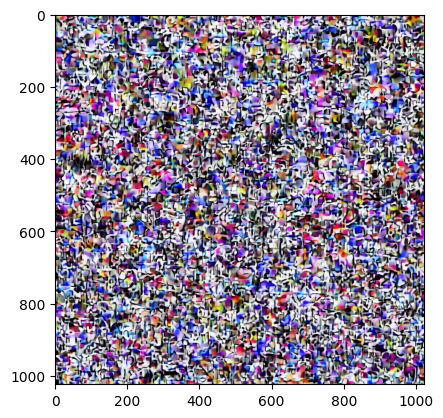

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


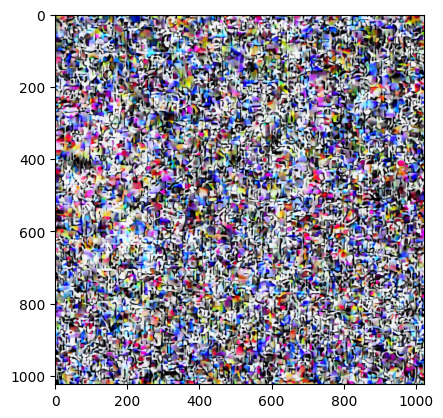

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


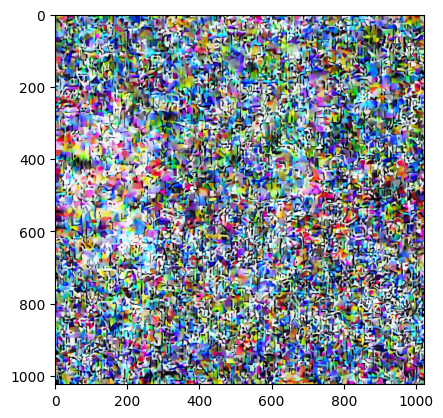

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


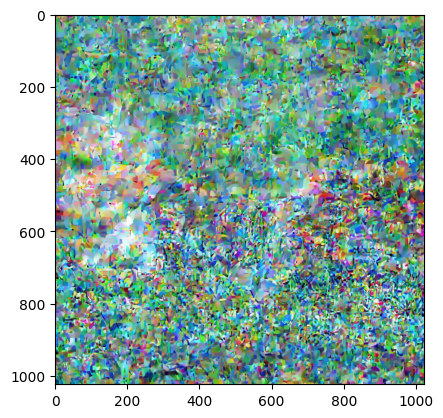

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024]) Pixel shape


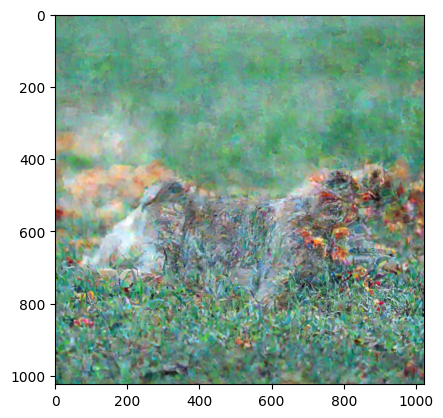

In [331]:
for latent in generated[::20]:
    decoded_inversion = movq.decode(latent)
    plt.imshow(transforms.Lambda(lambda t: (t + 1) / 2)(decoded_inversion)[0].permute(1, 2, 0).cpu())
    print(decoded_inversion.shape, "Pixel shape")
    plt.show()

torch.Size([1, 3, 1024, 1024]) Pixel shape


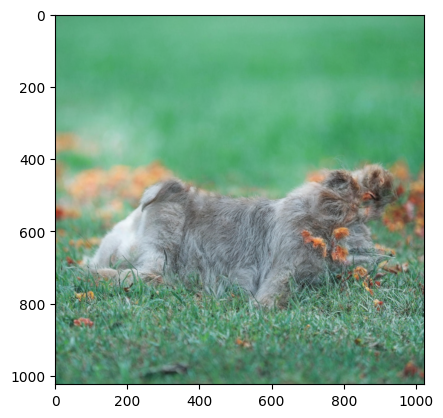

In [332]:
decoded_inversion = movq.decode(generated[-1])
plt.imshow(transforms.Lambda(lambda t: (t + 1) / 2)(decoded_inversion)[0].permute(1, 2, 0).cpu())
print(decoded_inversion.shape, "Pixel shape")
plt.show()